# RAPIDS & Scanpy Single-Cell RNA-seq Workflow on mouse NAc cells

Copyright (c) 2020, NVIDIA CORPORATION.

Licensed under the Apache License, Version 2.0 (the "License") you may not use this file except in compliance with the License. You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0 

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

This notebook demonstrates a single-cell RNA analysis workflow that begins with preprocessing a count matrix of size `(n_gene, n_cell)` and results in a visualization of the clustered cells for further analysis.

For demonstration purposes, we use a dataset of 1.3 M brain cells with Unified Virtual Memory to oversubscribe GPU memory.

## Import requirements

In [1]:
import numpy as np
import scanpy as sc
import anndata

import time
import os, wget

import cupy as cp
import cudf

from cuml.decomposition import PCA
from cuml.manifold import TSNE
from cuml.cluster import KMeans
from cuml.preprocessing import StandardScaler

import rapids_scanpy_funcs
import utils

import warnings
warnings.filterwarnings('ignore', 'Expected ')
warnings.simplefilter('ignore')
import pandas as pd
from sh import gunzip
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import rmm
rmm.reinitialize(managed_memory=True)
from rmm.allocators.cupy import rmm_cupy_allocator
import cupy
cupy.cuda.set_allocator(rmm_cupy_allocator)

import calculation_tool as ct
import gc
import cupy as cp
gc.collect()
cp.get_default_memory_pool().free_all_blocks()

/opt/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We use the RAPIDS memory manager to enable Unified Virtual Memory management, which allows us to oversubscribe the GPU memory.

## Input data

In the cell below, we provide the path to the sparse `.h5ad` file containing the count matrix to analyze. Please see the README for instructions on how to download the dataset we use here.

To run this notebook using your own dataset, please see the README for instructions to convert your own count matrix into this format. Then, replace the path in the cell below with the path to your generated `.h5ad` file.

In [ ]:
import os
import urllib.request
import gzip
import shutil

url_list=[r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5482106&format=file&file=GSM5482106%5FNAc%5FWT%5FRep1%5Fbarcodes%2Etsv%2Egz",
r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5482106&format=file&file=GSM5482106%5FNAc%5FWT%5FRep1%5Ffeatures%2Etsv%2Egz",
r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5482106&format=file&file=GSM5482106%5FNAc%5FWT%5FRep1%5Fmatrix%2Emtx%2Egz",
r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5482107&format=file&file=GSM5482107%5FNAc%5FWT%5FRep2%5Fbarcodes%2Etsv%2Egz",
r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5482107&format=file&file=GSM5482107%5FNAc%5FWT%5FRep2%5Ffeatures%2Etsv%2Egz",
r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5482107&format=file&file=GSM5482107%5FNAc%5FWT%5FRep2%5Fmatrix%2Emtx%2Egz",
r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5482108&format=file&file=GSM5482108%5FNAc%5FSetd1aHet%5FRep1%5Fbarcodes%2Etsv%2Egz",
r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5482108&format=file&file=GSM5482108%5FNAc%5FSetd1aHet%5FRep1%5Ffeatures%2Etsv%2Egz",
r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5482108&format=file&file=GSM5482108%5FNAc%5FSetd1aHet%5FRep1%5Fmatrix%2Emtx%2Egz",
r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5482109&format=file&file=GSM5482109%5FNAc%5FSetd1aHet%5FRep2%5Fbarcodes%2Etsv%2Egz",
r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5482109&format=file&file=GSM5482109%5FNAc%5FSetd1aHet%5FRep2%5Ffeatures%2Etsv%2Egz",
r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM5482109&format=file&file=GSM5482109%5FNAc%5FSetd1aHet%5FRep2%5Fmatrix%2Emtx%2Egz"]

def download_file(url, dir, file_name):
    full_path = os.path.join(dir, file_name)
    urllib.request.urlretrieve(url, full_path)
    # 以下のコメントアウト部分を活用する場合は、解凍の手順を追加することができます。
    # with gzip.open(full_path, 'rb') as f_in:
    #     with open(full_path[:-3], 'wb') as f_out:
    #         shutil.copyfileobj(f_in, f_out)

dir = "/data/mouse_NAc/"

for url in url_list:
    acc = url.split("acc=")[1].split("&")[0]
    file_name_from_url = url.split("file=")[1]

    # WTとSetd1aHetのサブフォルダを作成
    subfolder = "WT" if "WT" in file_name_from_url else "Setd1aHet"
    acc_dir = os.path.join(dir,subfolder, acc)
    os.makedirs(acc_dir, exist_ok=True)

    # 標準的なファイル名に変更（.gzを取り除く）
    standard_file_name = file_name_from_url.split('_')[-1].replace('.gz', '')
    
    if "barcodes" in file_name_from_url:
        standard_file_name = "barcodes.tsv.gz"
    elif "features" in file_name_from_url:
        standard_file_name = "features.tsv.gz"
    elif "matrix" in file_name_from_url:
        standard_file_name = "matrix.mtx.gz"
    
    # ファイルをダウンロード
    download_file(url, acc_dir, standard_file_name)


In [ ]:
# ダウンロードディレクトリ
base_dir = "/data/mouse_NAc/"

def read_10x_mtx(path, label):
    """10x mtxフォーマットのデータを読み込み、指定されたラベルを追加します。"""
    adata = sc.read_10x_mtx(
        path,
        var_names='gene_symbols',
        cache=True
    )
    adata.obs['label'] = label
    return adata

labels = ["WT", "Setd1aHet"]

all_adatas = []

for label in labels:
    label_dir = os.path.join(base_dir, label)
    gsm_dirs = [os.path.join(label_dir, d) for d in os.listdir(label_dir) if os.path.isdir(os.path.join(label_dir, d))]
    
    for gsm_dir in gsm_dirs:
        if os.path.exists(gsm_dir):
            all_adatas.append(read_10x_mtx(gsm_dir, label))

# 全てのAnnDataオブジェクトを1つに結合
combined_adata = all_adatas[0].concatenate(all_adatas[1:], join='outer')

# .h5ad形式で保存
combined_adata.write("/data/mouse_NAc/combined_data.h5ad")

## load data

preprocess_in_bulk
HTR1E is not included
HTR1E is removed from marker list
['CX3CR1', 'CLDN5', 'GLUL', 'NDRG2', 'PCDH15', 'PLP1', 'MBP', 'SATB2', 'SLC17A7', 'SLC17A6', 'GAD2', 'GAD1', 'SNAP25', 'HTR1A', 'HTR1B', 'HTR1D', 'HTR2A', 'HTR2B', 'HTR2C', 'HTR3A', 'HTR4', 'HTR5A', 'HTR6', 'HTR7', 'DRD1', 'DRD2', 'DRD3', 'DRD4', 'DRD5', 'HRH1', 'HRH2', 'HRH3', 'CHRM1', 'CHRM2', 'CHRM3', 'CHRM4', 'CHRM5', 'ADRA1A', 'ADRA1B', 'ADRA2A', 'ADRA2B', 'ADRA2C', 'ADRB1', 'ADRB2']
perform regression
perform scale
float32
Total Preprocessing time: 330.93583607673645
shape of adata: (38956, 21594)
shape of adata: (38956, 21594)
perform PCA
40
t-sne
UMAP
UMAP louvain


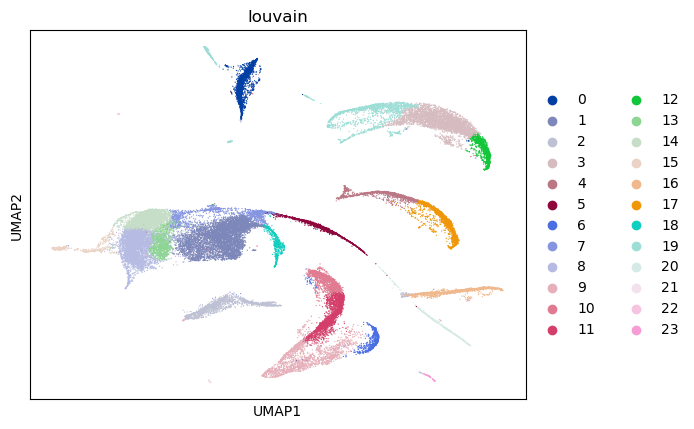

UMAP leiden


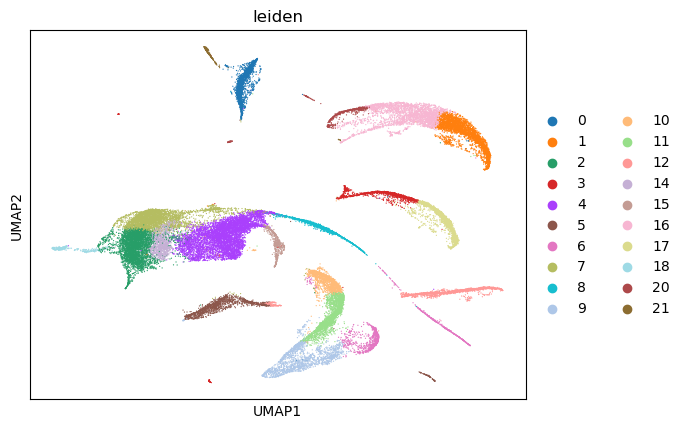

calc drug response
clz selective cells
# of clz selective cells: is_clz_selective
False    36875
True      2081
Name: count, dtype: int64


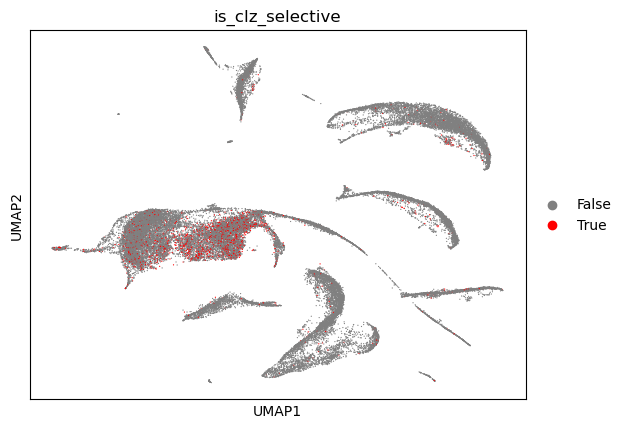

In [2]:
import calculation_tool as ct
file_path="/data/mouse_NAc/combined_data.h5ad"
adata,GPCR_df=ct.preprocess_adata_in_bulk(file_path,label=None)
GPCR_df.to_csv("/data/mouse_NAc/combined_data_GPCR_df.csv")

In [3]:
D_R_mtx,GPCR_type_df,drug_list,GPCR_list=ct.load_parameters()
params=ct.set_parameters_for_preprocess(GPCR_list)

In [ ]:
sc.pl.umap(adata, color=["leiden"])

In [4]:
import calculation_tool as ct
ct.drug_titeration(adata, GPCR_df, GPCR_type_df, drug_list, D_R_mtx)

AttributeError: module 'calculation_tool' has no attribute 'drug_titeration'

In [5]:
def calc_drug_response(adata,GPCR_df,GPCR_type_df,drug_list,D_R_mtx,drug_conc):
    #noramlize GPCR expression levels
    GPCR_adata=anndata.AnnData(X=GPCR_df)
    GPCR_adata_norm=sc.pp.normalize_total(GPCR_adata,target_sum=1e4,inplace=False)['X']
    GPCR_adata_norm_df=pd.DataFrame(GPCR_adata_norm,columns=GPCR_adata.var.index)
    norm_df=pd.DataFrame(GPCR_adata_norm)
    norm_col=[str[:-4] for str in GPCR_df.columns]
    norm_df.columns=norm_col
    
    GPCR_type_df=GPCR_type_df[GPCR_type_df.receptor_name.isin(norm_col)]
    
    Gs=GPCR_type_df[GPCR_type_df.type=="Gs"]["receptor_name"].values
    Gi=GPCR_type_df[GPCR_type_df.type=="Gi"]["receptor_name"].values
    Gq=GPCR_type_df[GPCR_type_df.type=="Gq"]["receptor_name"].values
    
    cAMP_df=pd.DataFrame(columns=drug_list)
    #Ca_df=pd.DataFrame(columns=drug_list)
    #drug_conc=D_R_mtx.median().median()*100
    for drug in drug_list:
        Gs_effect=(norm_df.loc[:,Gs]/(1+drug_conc/D_R_mtx.loc[drug,Gs])).sum(axis=1) #TODO ki値で割り算するときにlog換算すべきか
        Gi_effect=(norm_df.loc[:,Gi]/(1+drug_conc/D_R_mtx.loc[drug,Gi])).sum(axis=1)
        basal_cAMP=(norm_df.loc[:,Gs]-norm_df.loc[:,Gi]).sum(axis=1)
        #Gq_effect=(norm_df.loc[:,Gq]/D_R_mtx.loc[drug,Gq]).sum(axis=1)
        cAMPmod=(Gs_effect-Gi_effect)-basal_cAMP #Giの阻害→cAMP上昇、Gsの阻害→cAMP低下

        #Gs_effect=(norm_df.loc[:,Gs]/D_R_mtx.loc[drug,Gs]).sum(axis=1) 
        #Gi_effect=(norm_df.loc[:,Gi]/D_R_mtx.loc[drug,Gi]).sum(axis=1)
        #cAMPmod=Gi_effect-Gs_effect
        #Camod=-Gq_effect #Gq阻害→Ca低下
        cAMP_df[drug]=cAMPmod
        #Ca_df[drug]=Camod
        
    cAMP_df.index=adata.obs_names
    #Ca_df.index=adata.obs_names
    #Ca_df=Ca_df+10**(-4)
    for drug in drug_list:
        adata.obs['cAMP_%s'%drug]=cAMP_df[drug]
        #adata.obs['Ca_%s'%drug]=Ca_df[drug]
        
    return adata


def calc_drug_response_old(adata,GPCR_df,GPCR_type_df,drug_list,D_R_mtx,drug_conc):
    #noramlize GPCR expression levels
    GPCR_adata=anndata.AnnData(X=GPCR_df)
    GPCR_adata_norm=sc.pp.normalize_total(GPCR_adata,target_sum=1e4,inplace=False)['X']
    GPCR_adata_norm_df=pd.DataFrame(GPCR_adata_norm,columns=GPCR_adata.var.index)
    norm_df=pd.DataFrame(GPCR_adata_norm)
    norm_col=[str[:-4] for str in GPCR_df.columns]
    norm_df.columns=norm_col
    
    GPCR_type_df=GPCR_type_df[GPCR_type_df.receptor_name.isin(norm_col)]
    
    Gs=GPCR_type_df[GPCR_type_df.type=="Gs"]["receptor_name"].values
    Gi=GPCR_type_df[GPCR_type_df.type=="Gi"]["receptor_name"].values
    Gq=GPCR_type_df[GPCR_type_df.type=="Gq"]["receptor_name"].values
    
    cAMP_df=pd.DataFrame(columns=drug_list)
    #Ca_df=pd.DataFrame(columns=drug_list)
    #drug_conc=D_R_mtx.median().median()*100
    for drug in drug_list:
        #Gs_effect=(norm_df.loc[:,Gs]/(1+drug_conc/D_R_mtx.loc[drug,Gs])).sum(axis=1) #TODO ki値で割り算するときにlog換算すべきか
        #Gi_effect=(norm_df.loc[:,Gi]/(1+drug_conc/D_R_mtx.loc[drug,Gi])).sum(axis=1)
        #basal_cAMP=(norm_df.loc[:,Gs]-norm_df.loc[:,Gi]).sum(axis=1)
        #Gq_effect=(norm_df.loc[:,Gq]/D_R_mtx.loc[drug,Gq]).sum(axis=1)
        #cAMPmod=(Gs_effect-Gi_effect)-basal_cAMP #Giの阻害→cAMP上昇、Gsの阻害→cAMP低下

        Gs_effect=(norm_df.loc[:,Gs]/D_R_mtx.loc[drug,Gs]).sum(axis=1) 
        Gi_effect=(norm_df.loc[:,Gi]/D_R_mtx.loc[drug,Gi]).sum(axis=1)
        cAMPmod=Gi_effect-Gs_effect
        #Camod=-Gq_effect #Gq阻害→Ca低下
        cAMP_df[drug]=cAMPmod
        #Ca_df[drug]=Camod
        
    cAMP_df.index=adata.obs_names
    #Ca_df.index=adata.obs_names
    #Ca_df=Ca_df+10**(-4)
    for drug in drug_list:
        adata.obs['cAMP_%s'%drug]=cAMP_df[drug]
        #adata.obs['Ca_%s'%drug]=Ca_df[drug]
        
    return adata

def calc_clz_selective_cell(adata,drug_list,selectivity_threshold):
    adata.obs["is_clz_activated"]=np.zeros(len(adata.obs))
    adata.obs["is_clz_activated"][adata.obs["cAMP_CLOZAPINE"]>10]=1
    adata.obs["is_clz_activated"]=adata.obs["is_clz_activated"].astype("category")
    
    adata.obs["is_clz_inhibited"]=np.zeros(len(adata.obs))
    adata.obs["is_clz_inhibited"][adata.obs["cAMP_CLOZAPINE"]<-10]=1
    adata.obs["is_clz_inhibited"]=adata.obs["is_clz_inhibited"].astype("category")

    # 「CLOZAPINE」以外の薬に対応するカラム名のリストを作成
    drug_cols = [f"cAMP_{drug}" for drug in drug_list if drug != "CLOZAPINE"]

    # メモリ使用量削減のため、必要に応じて計算対象カラムを float32 にキャスト
    for col in drug_cols + ["cAMP_CLOZAPINE"]:
        adata.obs[col] = adata.obs[col].astype("float32")


    # ゼロ除算を避けるための小さな定数
    epsilon = 1e-9

    # 薬ごとの cAMP 値の平均（ゼロ除算防止のため epsilon を加算）
    adata.obs["cAMP_mean_other_than_czp"] = adata.obs[drug_cols].mean(axis=1) + epsilon


    # クロザピンに対するセレクティビティの計算（各細胞ごとにベクトル演算）
    adata.obs["cAMP_clz_selectivity"] = (adata.obs["cAMP_CLOZAPINE"] ** 2) / (adata.obs["cAMP_mean_other_than_czp"] ** 2)

    # selectivity_threshold と cAMP_CLOZAPINE > 0 の条件を満たす細胞をカテゴリ型でラベル付け
    adata.obs["is_clz_selective"] = (((adata.obs["cAMP_clz_selectivity"] > selectivity_threshold) & 
                                    (adata.obs["cAMP_CLOZAPINE"] > 0))
                                    ).astype("category")
    
    print("clz selective cells")
    print("# of clz selective cells:",adata.obs["is_clz_selective"].value_counts())
    num_clz_selective = adata.obs["is_clz_selective"].value_counts()[True]
    sc.pl.umap(adata, color=["is_clz_selective"],palette=["gray", "red"])
    return adata,num_clz_selective

Drug concentration: 0.001
clz selective cells
# of clz selective cells: is_clz_selective
False    38944
True        12
Name: count, dtype: int64


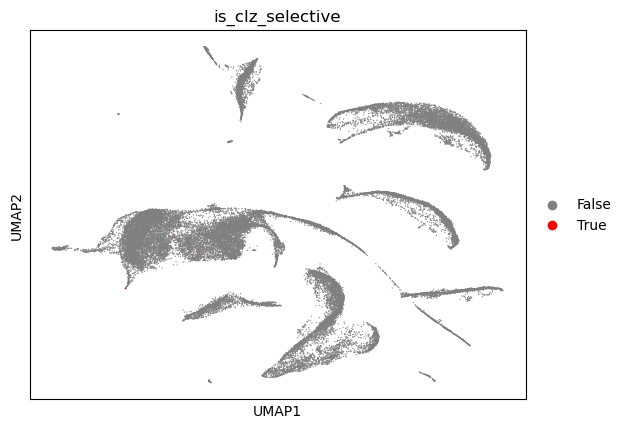

Drug concentration: 0.01
clz selective cells
# of clz selective cells: is_clz_selective
False    38944
True        12
Name: count, dtype: int64


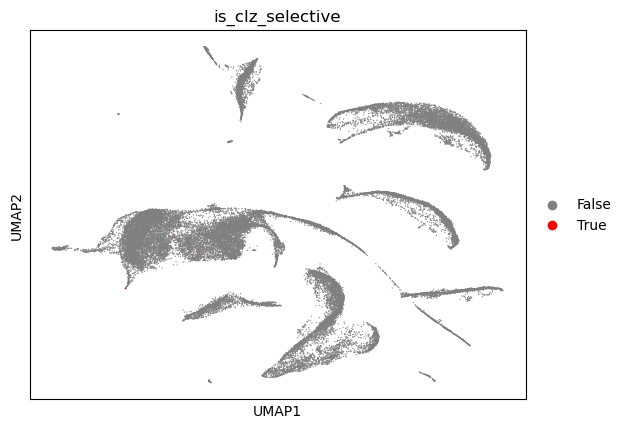

Drug concentration: 0.1
clz selective cells
# of clz selective cells: is_clz_selective
False    38944
True        12
Name: count, dtype: int64


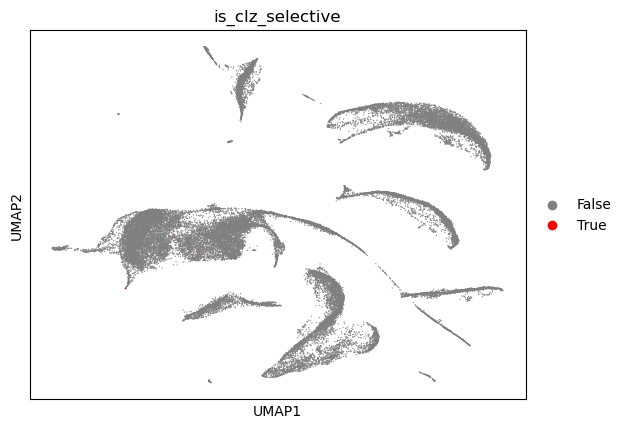

Drug concentration: 1
clz selective cells
# of clz selective cells: is_clz_selective
False    38845
True       111
Name: count, dtype: int64


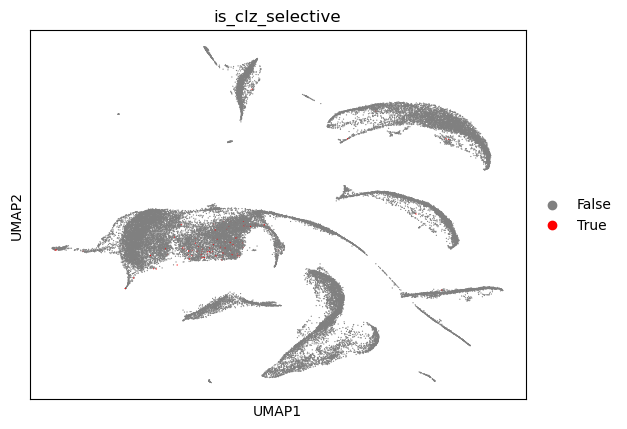

Drug concentration: 1.5848931924611136
clz selective cells
# of clz selective cells: is_clz_selective
False    38809
True       147
Name: count, dtype: int64


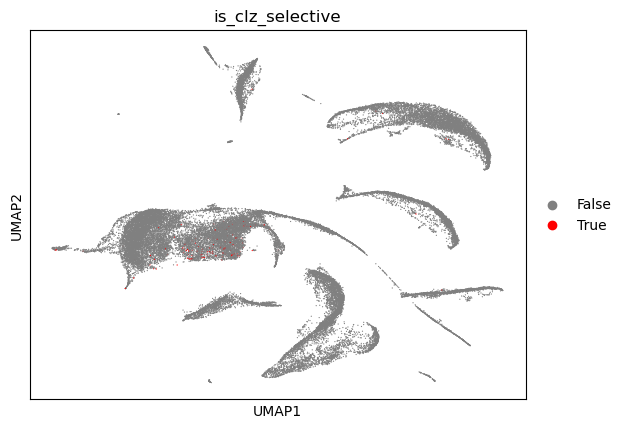

Drug concentration: 2.2387211385683394
clz selective cells
# of clz selective cells: is_clz_selective
False    38801
True       155
Name: count, dtype: int64


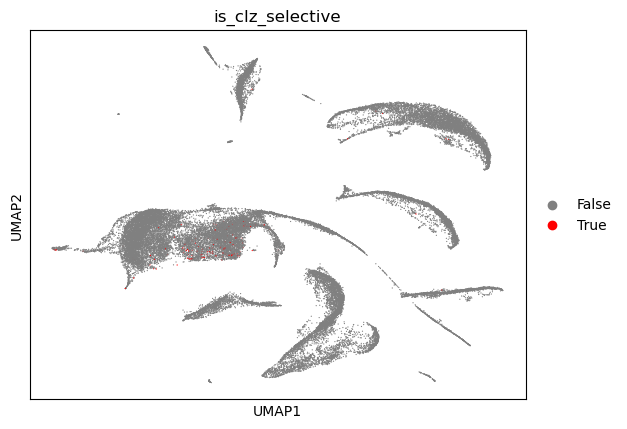

Drug concentration: 3.1622776601683795
clz selective cells
# of clz selective cells: is_clz_selective
False    37034
True      1922
Name: count, dtype: int64


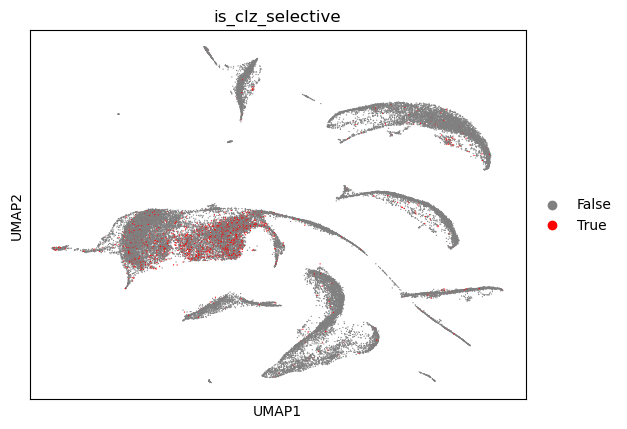

Drug concentration: 5.623413251903491
clz selective cells
# of clz selective cells: is_clz_selective
False    36939
True      2017
Name: count, dtype: int64


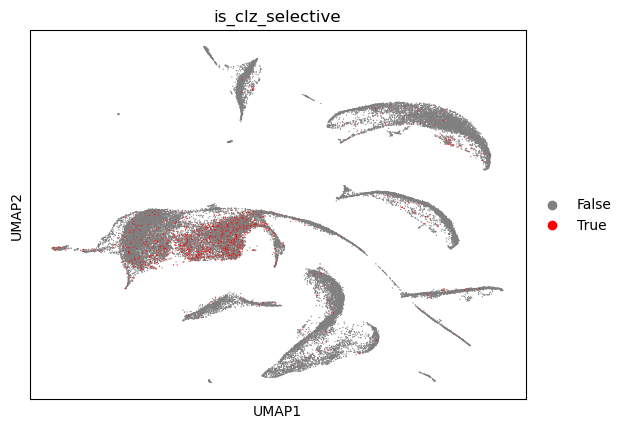

Drug concentration: 10
clz selective cells
# of clz selective cells: is_clz_selective
False    36900
True      2056
Name: count, dtype: int64


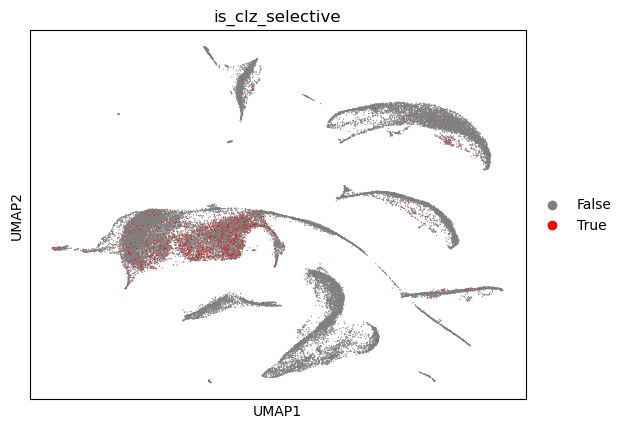

Drug concentration: 31.622776601683793
clz selective cells
# of clz selective cells: is_clz_selective
False    36883
True      2073
Name: count, dtype: int64


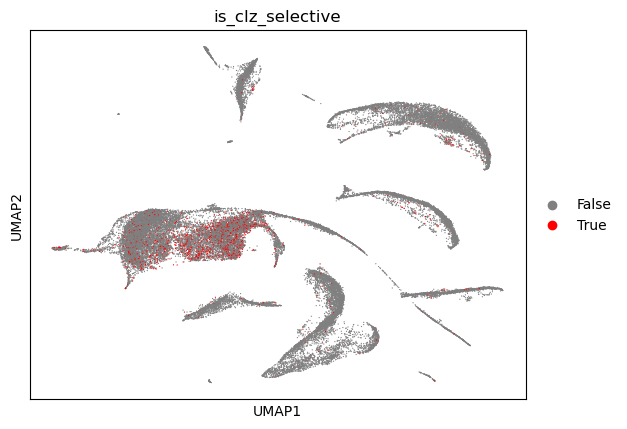

Drug concentration: 100
clz selective cells
# of clz selective cells: is_clz_selective
False    36920
True      2036
Name: count, dtype: int64


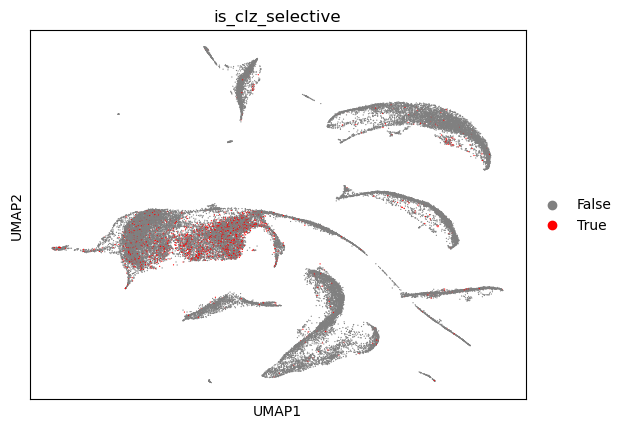

Drug concentration: 316.22776601683796
clz selective cells
# of clz selective cells: is_clz_selective
False    36968
True      1988
Name: count, dtype: int64


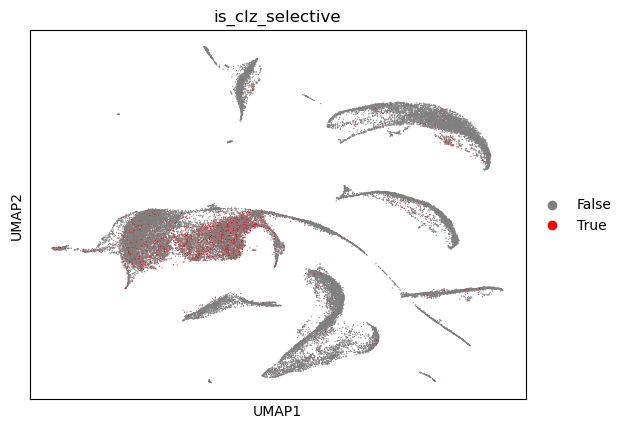

Drug concentration: 1000
clz selective cells
# of clz selective cells: is_clz_selective
False    36991
True      1965
Name: count, dtype: int64


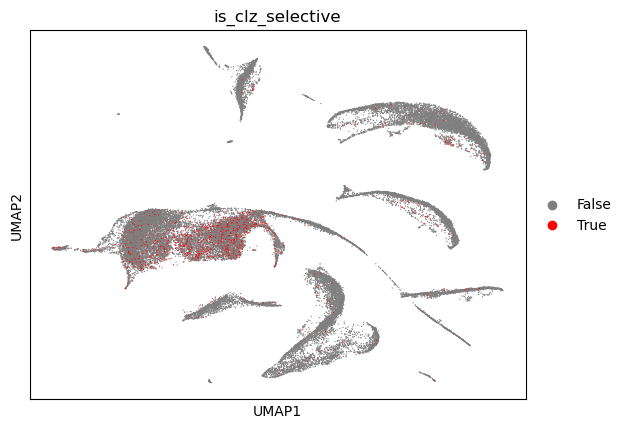

Drug concentration: 10000
clz selective cells
# of clz selective cells: is_clz_selective
False    37085
True      1871
Name: count, dtype: int64


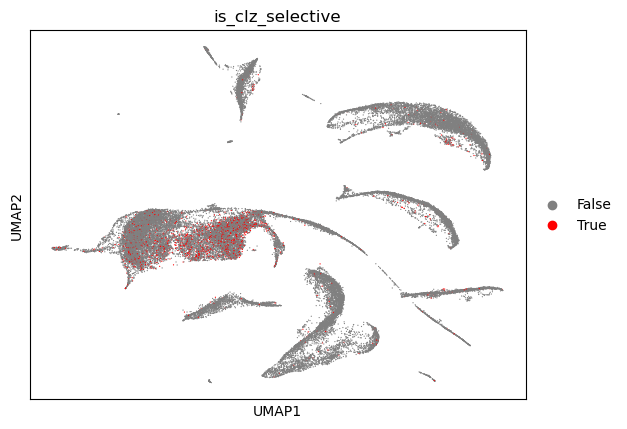

Drug concentration: 100000
clz selective cells
# of clz selective cells: is_clz_selective
False    37098
True      1858
Name: count, dtype: int64


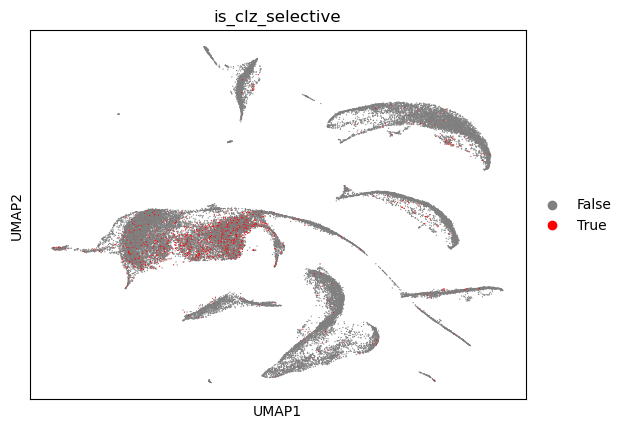

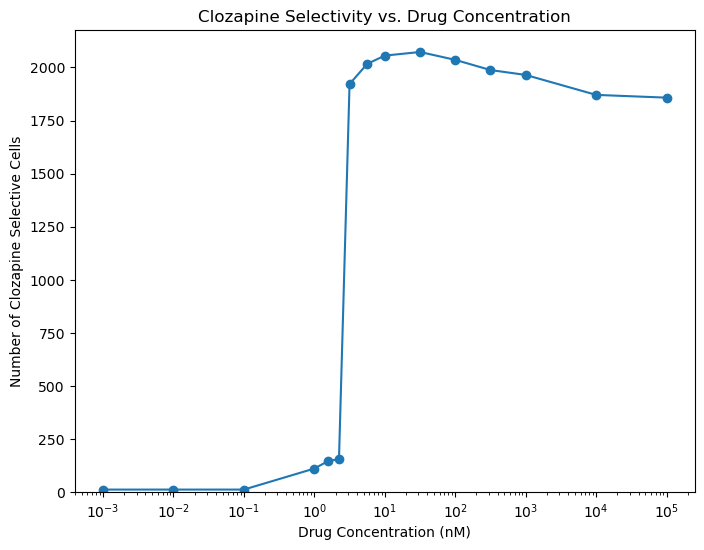

In [6]:
import bisect
# べき指数が -3 から +5 までのリスト（必要に応じて変更）
powers = [i for i in range(-3, 6)]
bisect.insort(powers, 0.2)
bisect.insort(powers, 0.35)
bisect.insort(powers, 0.5)
bisect.insort(powers, 0.75)
#bisect.insort(powers, 1.2)
bisect.insort(powers, 1.5)
bisect.insort(powers, 2.5)

# 10のべき乗の値をリストにする（薬剤濃度リスト）
drug_conc_list = [10**i for i in powers]

# 各濃度におけるクロザピン選択細胞数を格納するリスト
num_clz_list = []

for drug_conc in drug_conc_list:
    print("Drug concentration:", drug_conc)
    # 薬剤反応の計算（関数の実装に依存）
    adata = calc_drug_response(adata, GPCR_df, GPCR_type_df, drug_list, D_R_mtx, drug_conc)
    # クロザピン選択細胞の計算（この関数は adata と num_clz_selective を返すと仮定）
    adata, num_clz_selective = calc_clz_selective_cell(adata, drug_list, selectivity_threshold=1.5)
    num_clz_list.append(num_clz_selective)

# プロット
plt.figure(figsize=(8, 6))
plt.plot(drug_conc_list, num_clz_list, marker='o', linestyle='-')
plt.xscale('log')  # x軸を対数スケールに設定
plt.xlabel("Drug Concentration (nM)")
plt.ylabel("Number of Clozapine Selective Cells")
plt.title("Clozapine Selectivity vs. Drug Concentration")
plt.ylim(bottom=0) 
#plt.grid(True)
plt.show()